# Allen Wong Machine Learning Capstone Project

This project is based on the Airbnb New User Bookings Kaggle Challenge (site: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings). The notebook will be divided into three parts: training set, testing set and generating output for kaggle submission. I will be performing: 

- Training Set
 - Data Pre-processing; 
 - Training on several tree based models; 
 - Tuning the hyperparameters through Grid Search and Random Search;
 - Training the optimal model
 - Identifying the 5 most important features
 - Comparing the performance of the full model and reduced model


- Testing Set
 - Data Preprocessing;
 - Evaluating the full model against the test set
 
 
- Submission to Kaggle

## Training Set

### Data Pre-Processing

In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display

#import starting pre-processed files
aggregated_web_sessions = pd.read_csv("Aggregation of web session log details 12.5.17 101pm ET (with user and time secs elapsed mapping).csv") #processed web sessions data, further details in capstone writeup
train_users_AWprocessed = pd.read_csv('train_users_2_AW_processed.csv') #processed train users file, e.g. deleted any users age greater than 115. further details in capstone writeup
train_users_joined = pd.merge(train_users_AWprocessed, aggregated_web_sessions, left_on = 'user_id', right_on = 'user_id', how = 'left') #combining web sessions data with train users data

#additional cleanups of pre-processed files
del train_users_joined['timestamp_first_active'] #assumed that this field is not important as there are only one values for all users
train_users_joined['age'].fillna(-1, inplace=True) #any users with missing age are replaced with a -1 value. The negative sign is there to help the model know that these values are completely different from all other values
train_users_joined['first_affiliate_tracked'].fillna('missing', inplace=True) 
train_users_joined.fillna(-1, inplace=True) 

#write to excel and reorder so that the 15,500 users are placed on the top first. Reordered the users based on whether secs elapsed is a positive value or -1 (missing from the data)
#writer = pd.ExcelWriter('train_users_joined(placed 15500 first)_test.xlsx') #already wrote these files when running this. showing code for illustrative purposes
#train_users_joined.to_excel(writer,'Sheet1')
#writer.save()

#import the csv files with 15,500 users reordered
train_users_final = pd.read_csv('train_users_joined(placed 15500 first)_test3 12.24.17 430pm ET.csv')

#bring in the coordinates and distance km2 information that the 213,451 training users will all see
train_users_final_coordinates = pd.read_csv('Countries 213451.csv')

#join the 15,500 reordered users file with the Countries data
train_users_final_join_coordinates = pd.concat([train_users_final, train_users_final_coordinates], axis=1, join='inner')


#split the resulting data first so that the first 15500 users are separated out. The remaining data will then be shuffled and these two 
#dataframes will be joined back together 
train_users_final_1of2 = train_users_final_join_coordinates[0:15500] #first 15500 users
train_users_final_2of2 = train_users_final_join_coordinates[15500:] #split these users out and shuffle

train_users_final_2of2 = train_users_final_2of2.sample(frac=1) #shuffle this dataframe in case it needs to be shuffled. The shuffle function will be turned off later in splitting the training and test data

#rejoined the two split dataframes back together
train_users_final_after_shuffle = pd.concat([train_users_final_1of2, train_users_final_2of2])


### Features & Target Label Splitting, One-Hot Encoding and Feature scaling

The training set is almost ready at this point. All of the necessary information has been combined into one file and the users have been reordered such that only the users with web sessions activity appear first. This will be necessary when we split the data between the training set and the cross validation set; we want the data distribution of the cross validation set to be similar to the data distribution of the final test set. The following steps will get our data ready for training. 

In [2]:
#delete user_id first so that one-hot encoding does not throw a memory error
del train_users_final_after_shuffle['user_id']

# Split the data into features and target label
country_raw = train_users_final_after_shuffle['country_destination']
features_raw = train_users_final_after_shuffle.drop('country_destination', axis = 1)

# One-hot encode features and country data
features_one_hot = pd.get_dummies(features_raw)

# Encode the 'country_raw' data to numerical values
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
le.fit(country_raw)
country = le.transform(country_raw)

# Print the number of features after one-hot encoding
encoded = list(features_one_hot.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

1144 total features after one-hot encoding.


The features are currently stored as a numpy. We need to take the following additional steps to convert it from a numpy to a dataframe.

In [3]:
#Get the column labels. 
columns_of_features_one_hot = features_one_hot.dtypes.index #Ref: https://stackoverflow.com/questions/24901766/python-how-to-get-column-names-from-pandas-dataframe-but-only-for-continuous

index_of_features_one_hot=range(0,213451) #Get the row labels.

#Ref: https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num
#Ref: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
#Ref: http://benalexkeen.com/feature-scaling-with-scikit-learn/
from sklearn.preprocessing import RobustScaler

features_scaled = RobustScaler().fit_transform(features_one_hot.values)

features_scaled_df = pd.DataFrame(features_scaled, index=index_of_features_one_hot, columns=columns_of_features_one_hot)


Finally! We are ready to split the dataset between the training and cross validation set.

### Splitting dataset between Training and Cross Validation Set

In [4]:
# Import train_test_split
from sklearn.model_selection import train_test_split

#Now that the 15,500 users with web sessions are on the top and the remaining users have been shuffled, we can call train_test_split with shuffle equals false so
#we make sure that those 15,500 users are in the training set and the validation set has the same data distribution as the test set
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled_df, 
                                                    country, 
                                                    test_size = 0.2, 
                                                    random_state = 0,
                                                    shuffle = False)


# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 170760 samples.
Testing set has 42691 samples.


### Training on Several Tree Based Models

Our dataset is ready for training now!I will be applying 6 different models to the training set. They are:
 - AdaBoost 
 - Bagging 
 - Decision Tree
 - ExtraTrees
 - Gradient Boosting
 - Random Forest
 
I will also be setting a timer for each of the above classifiers to get a sense of each model's efficiency.

In [5]:
import math

#first define calculation for nDCG
def calculate_nDCG(x):
    nDCG = [] 
    for element in x:
        nDCG.append((2 - 1)/math.log(element+1, 2))
    return nDCG

# #This line will go through each element in the maximal_value_tracking_index (which is a list that keeps track of the rank of the predictions)
# #and compares it y_test. If a given array has the same value, then a 1 is placed into index_for_DCG, otherwise the rank of a given country in predictions (referencing the correct country from y_test)
# #will be appended to index_for_DCG. Ideal case is an index of all 1's
#Ref: https://stackoverflow.com/questions/6422700/how-to-get-indices-of-a-sorted-array-in-python
#Ref: https://stackoverflow.com/questions/6193498/pythonic-way-to-find-maximum-value-and-its-index-in-a-list
#Ref: https://stackoverflow.com/questions/5284646/rank-items-in-an-array-using-python-numpy
#Ref: http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html

from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np
import operator
import time 

#convert y_train to the appropriate dimension
y2 = y_train
Y = np.vstack((y_train, y2)).T

clf_A = AdaBoostClassifier(n_estimators= 100, random_state=1)
clf_B = BaggingClassifier(n_estimators= 100, random_state=1)
clf_C = DecisionTreeClassifier(random_state=1) 
clf_D = ExtraTreesClassifier(n_estimators= 100, random_state=1)
clf_E = GradientBoostingClassifier(n_estimators= 100, random_state=1)
clf_F = RandomForestClassifier(n_estimators= 100, random_state=1)

results = {} #create a dictionary for the results
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F]:
    tic = time.time()      #start the timer
    clf_name = clf.__class__.__name__ #assign the classifier name to the clf_name variable
    clf_specific = clf 
    
    multi_target = MultiOutputClassifier(clf_specific, n_jobs=-1) #jobs is the number of core to use. Since it is set to -1, all cores are being used
    multi_target.fit(X_train, Y).predict(X_train) 
    predictions = multi_target.predict_proba(X_test)[0] #this will return an array with 12 columns that predicts the probability of the new user going to each country
    maximal_value_tracking_index =[]

    for element in predictions:
        order = element.argsort()
        rank = order.argsort()
        maximal_value_tracking_index.append(rank+1)

    
    index_for_DCG =[]
    
    i=0
    for rank_element in maximal_value_tracking_index:
        if rank_element[y_test[i]] == 12: #maximal probability
            index_for_DCG.append(1)
        else:
            if rank_element[y_test[i]] == 1:  #1 is a special number to mean that both the prediction and true value matches. In this line, 1 means the prediction was ranked last
                index_for_DCG.append(12)
            else:
                index_for_DCG.append(rank_element[y_test[i]])        
        i=i+1

    calculate_nDCG(index_for_DCG)
    toc = time.time() #stop the timer 
    total_time = toc - tic 
    results[clf_name] = [sum(calculate_nDCG(index_for_DCG))/float(len(calculate_nDCG(index_for_DCG))), total_time]
    
print(results)

{'AdaBoostClassifier': [0.9141842247093165, 447.74178647994995], 'BaggingClassifier': [0.904545723784987, 5557.759644508362], 'DecisionTreeClassifier': [0.8693511814527409, 112.72081208229065], 'ExtraTreesClassifier': [0.8981451797755682, 549.6879096031189], 'GradientBoostingClassifier': [0.913931656817523, 27350.038553714752], 'RandomForestClassifier': [0.9047377244170851, 260.956650018692]}


Now that we know which is the best classifier, I will employ Grid Search and Random Search to find the best hyperparameters. For both search, I will be using accuracy as the scorer, since this function is already built-in and it would also give me a better sense of how the model is performing rather than the somewhat inflated nDCG score.

### Tuning the hyperparameters - Grid Search

In [6]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Initialize the classifier
clf = AdaBoostClassifier(random_state=1)

# Parameters to tune
parameters = {'n_estimators': [50, 200, 300, 400, 500], 
              'learning_rate': [0.2, 0.4, 0.6, 0.8, 1], 
              }

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring='accuracy')

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
best_predictions = best_clf.predict(X_test)

# Report accuracy score and print the grid object with the best parameters
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print(grid_obj.best_params_)


Optimized Model
------
Final accuracy score on the testing data: 0.8752
{'learning_rate': 0.8, 'n_estimators': 50}


It's been said that Random Search is a better search than Grid Search. Let's see if the results differ.

### Tuning the hyperparameters - Random Search

In [7]:
#Import 'RandomizedSearchCV'
from sklearn.model_selection import RandomizedSearchCV

# Initialize the classifier
clf_Rand = AdaBoostClassifier(random_state=1)

# Parameters to tune
parameters = {'n_estimators': [50, 200, 300, 400, 500], 
              'learning_rate': [0.2, 0.4, 0.6, 0.8, 1], 
              }

# Perform randomized search on the classifier using 'scorer' as the scoring method using RandomizedSearchCV()
grid_obj_Rand = RandomizedSearchCV(clf_Rand, parameters, scoring='accuracy')

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_Rand = grid_obj_Rand.fit(X_train, y_train)

# Get the estimator
best_clf_Rand = grid_fit_Rand.best_estimator_

# Make predictions using the optimized model
best_predictions_Rand = best_clf_Rand.predict(X_test)

# Report accuracy score and print the grid object with the best parameters
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions_Rand)))
print(grid_obj_Rand.best_params_)


Optimized Model
------
Final accuracy score on the testing data: 0.8752
{'n_estimators': 50, 'learning_rate': 0.8}


Now that we know the appropriate hyperparameters, let's run the optimal model!

### Running the Optimal Model

In [8]:
#https://stackoverflow.com/questions/34214087/how-do-you-access-tree-depth-in-pythons-scikit-learn#Running Optimal Model

from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import shuffle
import numpy as np
import operator
import time 

#convert y_train to the appropriate dimension
y2 = y_train
Y = np.vstack((y_train, y2)).T

clf_Optimized = AdaBoostClassifier(n_estimators=50, learning_rate=0.8, random_state=1)

results = {} #create a dictionary for the results
for clf in [clf_Optimized]:
    tic = time.time()      #start the timer
    clf_name = clf.__class__.__name__ #assign the classifier name to the clf_name variable
    clf_specific = clf 
    
    multi_target = MultiOutputClassifier(clf_specific, n_jobs=-1) #jobs is the number of core to use. Since it is set to -1, all cores are being used
    multi_target.fit(X_train, Y).predict(X_train) 
    predictions = multi_target.predict_proba(X_test)[0] #this will return an array with 12 columns that predicts the probability of the new user going to each country
    maximal_value_tracking_index =[]

    for element in predictions:
        order = element.argsort()
        rank = order.argsort()
        maximal_value_tracking_index.append(rank+1)

    
    index_for_DCG =[]
    
    i=0
    for rank_element in maximal_value_tracking_index:
        if rank_element[y_test[i]] == 12: #maximal probability
            index_for_DCG.append(1)
        else:
            if rank_element[y_test[i]] == 1:  #1 is a special number to mean that both the prediction and true value matches. In this line, 1 means the prediction was ranked last
                index_for_DCG.append(12)
            else:
                index_for_DCG.append(rank_element[y_test[i]])        
        i=i+1

    calculate_nDCG(index_for_DCG)
    toc = time.time() #stop the timer 
    total_time = toc - tic 
    results[clf_name] = [sum(calculate_nDCG(index_for_DCG))/float(len(calculate_nDCG(index_for_DCG))), total_time]
    
print(results)

{'AdaBoostClassifier': [0.9141609121322275, 155.86502981185913]}


Let's move on to see what are the top 5 most critical features of this model.

### Identifying the 5 Most Important Features

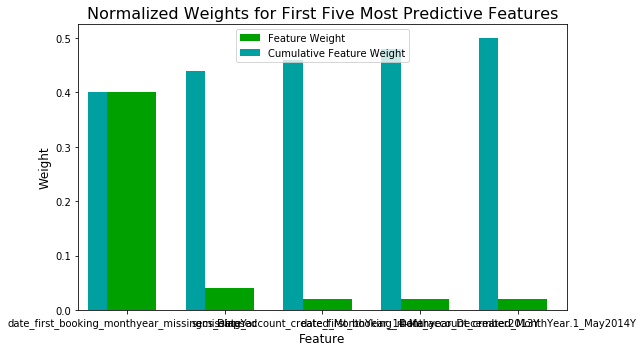

In [9]:
#run the optimal model
model = AdaBoostClassifier(n_estimators=50, learning_rate=0.8, random_state=1).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

import visuals2 as vs #this file was from the finding donors project

# Plot
vs.feature_plot(importances, X_train, y_train)

Let's get a better reading of these features. 

In [10]:
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:]]
print(columns[:5])

['date_first_booking_monthyear_missingmissingY' 'secs_elapsed'
 'Date_account_created_MonthYear_14-Mar'
 'date_first_booking_monthyear_December2013Y'
 'Date_account_created_MonthYear.1_May2014Y']


Let's compare the performance of the full model against the reduced model. 

### Comparison of Full Model vs. Reduced Model

In [11]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]] #from finding donors
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]] #from finding donors

# Train on the "best" model found from random search earlier
clf_reduced = AdaBoostClassifier(n_estimators=50, learning_rate=0.8, random_state=1).fit(X_train_reduced, y_train)
clf_full = AdaBoostClassifier(n_estimators=50, learning_rate=0.8, random_state=1).fit(X_train, y_train)

# Make new predictions
reduced_predictions = clf_reduced.predict(X_test_reduced)
full_predictions = clf_full.predict(X_test)

print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, full_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))


Final Model trained on full data
------
Accuracy on testing data: 0.8752

Final Model trained on reduced data
------
Accuracy on testing data: 0.8752


Let's now turn to the test set and examine how our model will perform. 

## Test Set

### Data Pre-processing

In [12]:
#import somewhat pre-processed test set
test_users_AWprocessed = pd.read_csv('test_usersAW processed 12.31.17 1059am ET.csv')

#similar to before, bring in the coordinates and distance km2 of destination countries
test_users_final_coordinates = pd.read_csv('Countries 62096.csv')

#join the two datasets
test_users_final_join_coordinates = pd.concat([test_users_AWprocessed, test_users_final_coordinates], axis=1, join='inner')

#both the test set and training set need to have the same number of features for the model to run. 103 features needed to be added to the test set. These dummy features have a value of 0
test_dummy_features = pd.read_csv('103 dummy features.csv')

#join all the data together
test_users_final_join_coordinates_f = pd.concat([test_users_final_join_coordinates, test_dummy_features], axis=1, join='inner')



### Features & Target Label Splitting, One-Hot Encoding and Feature scaling

In [13]:
#delete the user_id to prevent it from throwing a memory error
del test_users_final_join_coordinates_f['id']

# Split the data into features and target label
country_raw_test = test_users_final_join_coordinates_f['country_destination']
features_raw_test = test_users_final_join_coordinates_f.drop('country_destination', axis = 1)

# One-hot encode features and country data
features_one_hot_test = pd.get_dummies(features_raw_test)

# Encode the 'country_raw' data to numerical values
from sklearn.preprocessing import LabelEncoder
le_test= LabelEncoder()
le_test.fit(country_raw_test)
country_test = le.transform(country_raw_test)

# Print the number of features after one-hot encoding
encoded_test = list(features_one_hot_test.columns)
print("{} total features after one-hot encoding.".format(len(encoded_test)))

1144 total features after one-hot encoding.


In [14]:
#Get the column labels. This is for the step where we convert the scaled numpy to a dataframe
columns_of_features_one_hot_test = features_one_hot_test.dtypes.index #Ref: https://stackoverflow.com/questions/24901766/python-how-to-get-column-names-from-pandas-dataframe-but-only-for-continuous
index_of_features_one_hot_test=range(0,62096) #Get the row labels. This is for the step where we convert the scaled numpy to a dataframe

#Ref: https://stackoverflow.com/questions/35723472/how-to-use-sklearn-fit-transform-with-pandas-and-return-dataframe-instead-of-num

features_scaled_test = RobustScaler().fit_transform(features_one_hot_test.values)

features_scaled_df_test = pd.DataFrame(features_scaled_test, index=index_of_features_one_hot_test, columns=columns_of_features_one_hot_test)


In [15]:
# Import train_test_split
from sklearn.model_selection import train_test_split

#Now that the 15,500 users with web sessions are on the top and the remaining users have been shuffled, we can call train_test_split with shuffle equals false so
#we make sure that those 15,500 users are in the training set and the validation set has the same data distribution as the test set
# Split the 'features' and 'income' data into training and testing sets
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(features_scaled_df_test, 
                                                    country_test, 
                                                    test_size = 0, 
                                                    random_state = 0,
                                                    shuffle = False)


# Show the results of the split
print("Training set has {} samples.".format(X_train_t.shape[0]))
print("Testing set has {} samples.".format(X_test_t.shape[0]))


Training set has 62096 samples.
Testing set has 0 samples.


In [16]:
#convert y_train to the appropriate dimension
y2 = y_train
Y = np.vstack((y_train, y2)).T

clf_A_t = AdaBoostClassifier(n_estimators= 50, learning_rate=0.8, random_state=1)

results = {} #create a dictionary for the results
for clf in [clf_A_t]:
    tic = time.time()      #start the timer
    clf_name = clf.__class__.__name__ #assign the classifier name to the clf_name variable
    clf_specific = clf 
    
    multi_target = MultiOutputClassifier(clf_specific, n_jobs=-1) #jobs is the number of core to use. Since it is set to -1, all cores are being used
    multi_target.fit(X_train, Y).predict(X_train) 
    predictions = multi_target.predict_proba(X_train_t)[0] #this will return an array with 12 columns that predicts the probability of the new user going to each country
    maximal_value_tracking_index =[]

    for element in predictions:
        order = element.argsort()
        rank = order.argsort()
        maximal_value_tracking_index.append(rank+1)

    
    index_for_DCG =[]
    
    i=0
    for rank_element in maximal_value_tracking_index:
        if rank_element[y_train_t[i]] == 12: #maximal probability
            index_for_DCG.append(1)
        else:
            if rank_element[y_train_t[i]] == 1:  #1 is a special number to mean that both the prediction and true value matches. In this line, 1 means the prediction was ranked last
                index_for_DCG.append(12)
            else:
                index_for_DCG.append(rank_element[y_train_t[i]])        
        i=i+1

    calculate_nDCG(index_for_DCG)
    toc = time.time() #stop the timer 
    total_time = toc - tic 
    results[clf_name] = [sum(calculate_nDCG(index_for_DCG))/float(len(calculate_nDCG(index_for_DCG))), total_time]
    
print(results)

{'AdaBoostClassifier': [1.0, 169.42703485488892]}


## Generating Output for Submission to Kaggle

In [17]:
#create the country labels
label_spelled_out = ['AU', 'DE', 'NL', 'PT', 'IT', 'ES', 'GB', 'CA', 'FR', 'other', 'US', 'NDF']

#sort the labels
sort_label_spelled_out = sorted(label_spelled_out)

#create an array with the same shape as the testing set, 
#Ref: https://stackoverflow.com/questions/1550130/cloning-row-or-column-vectors
country_labels = np.tile(np.asarray(sort_label_spelled_out), (62096,1)) 

#remove "array" from beginning and "dtype" at end
maximal_value_tracking_index = np.asarray(maximal_value_tracking_index) 

#for each element, in each array, assign country_labels with the value in maximal value tracking. Remember, 12 is the largest and considerd the country most likely to vist
#Ref: https://stackoverflow.com/questions/6618515/sorting-list-based-on-values-from-another-list
i=0
country_labels_maximal_tracking = []
for element in country_labels:
    country_labels_maximal_tracking.append(list(zip(maximal_value_tracking_index[i],country_labels[i])))
    i=i+1
    
#sort the labels in reverse order
for element in country_labels_maximal_tracking:
    element.sort(reverse=True)
    
#extract the country from each subarray in country_labels_maximal_tracking
country_labels_sorted =[]
for element in list(country_labels_maximal_tracking):
    tracking_array = []
    i=0
    for sub_element in element:  
        if i<5:                                     #keep the first 5 elements in each subarray   
            tracking_array.append(sub_element[1])
            i=i+1
        else:
            None
    country_labels_sorted.append(tracking_array)
    

Final step below will extract the output above and put it into a csv file

In [18]:
writer = pd.ExcelWriter('AW_top_five_countries_robust_scaler.xlsx')
top_five_countries = pd.DataFrame(data=country_labels_sorted) #convert index to dataframe
top_five_countries.to_excel(writer,'Sheet1')
writer.save()

## Addendum

### Benchmark Model

In [19]:
#convert y_train to the appropriate dimension
y2 = y_train
Y = np.vstack((y_train, y2)).T

clf_benchmark = RandomForestClassifier(random_state=1)

results = {} #create a dictionary for the results
for clf in [clf_benchmark]:
    tic = time.time()      #start the timer
    clf_name = clf.__class__.__name__ #assign the classifier name to the clf_name variable
    clf_specific = clf 
    
    multi_target = MultiOutputClassifier(clf_specific, n_jobs=-1) #jobs is the number of core to use. Since it is set to -1, all cores are being used
    multi_target.fit(X_train, Y).predict(X_train) 
    predictions = multi_target.predict_proba(X_test)[0] #this will return an array with 12 columns that predicts the probability of the new user going to each country
    maximal_value_tracking_index =[]

    for element in predictions:
        order = element.argsort()
        rank = order.argsort()
        maximal_value_tracking_index.append(rank+1)

    
    index_for_DCG =[]
    
    i=0
    for rank_element in maximal_value_tracking_index:
        if rank_element[y_test[i]] == 12: #maximal probability
            index_for_DCG.append(1)
        else:
            if rank_element[y_test[i]] == 1:  #1 is a special number to mean that both the prediction and true value matches. In this line, 1 means the prediction was ranked last
                index_for_DCG.append(12)
            else:
                index_for_DCG.append(rank_element[y_test[i]])        
        i=i+1

    calculate_nDCG(index_for_DCG)
    toc = time.time() #stop the timer 
    total_time = toc - tic 
    results[clf_name] = [sum(calculate_nDCG(index_for_DCG))/float(len(calculate_nDCG(index_for_DCG))), total_time]
    
print(results)

{'RandomForestClassifier': [0.8994321229560059, 50.84402871131897]}
